In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from datetime import datetime
import ta
import mplfinance as mpf

# import tensorflow.compat.v1.keras.layers.CuDNNLSTM as CuDNNLSTM

In [2]:
import tensorflow as tf

# Set TensorFlow to only allocate memory on the GPU when needed
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
# Load the Bitcoin price data
bitcoin_data = pd.read_csv(r'C:\Users\MrBios\Documents\Development\IA-BTC-2023\csv\bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

# Drop missing values
bitcoin_data.dropna(inplace=True)


In [4]:
# Keep the necessary columns
bitcoin_data = bitcoin_data[['Timestamp', 'Open', 'High', 'Low', 'Close']]

bitcoin_data = bitcoin_data.tail(5000)

In [5]:
# # Convert Timestamp to datetime format
# bitcoin_data['Timestamp'] = pd.to_datetime(bitcoin_data['Timestamp'], unit='s')

# # Compute RSI
# bitcoin_data['RSI'] = ta.momentum.rsi(close=bitcoin_data["Close"], fillna=True)

# # Compute MACD
# bitcoin_data['MACD'] = ta.trend.macd(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['MACD_signal'] = ta.trend.macd_signal(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['MACD_diff'] = ta.trend.macd_diff(close=bitcoin_data["Close"], fillna=True)


In [6]:
# Prepare the data for training
# Prepare the data for training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(bitcoin_data[['Open', 'High', 'Low', 'Close']])
# scaled_data = scaler.fit_transform(bitcoin_data[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff']])
scaled_data = scaler.fit_transform(bitcoin_data.drop(columns=['Timestamp']))


In [7]:
num_features = scaled_data.shape[1]

In [8]:
timeframe = 60
X = []
y = []
for i in range(timeframe, len(scaled_data) - 10):
    X.append(scaled_data[i - timeframe:i, :])
    y.append(scaled_data[i:i + 10, :3])  # Predicting OHLC columns
X = np.array(X)
y = np.array(y)

In [9]:
X.shape, y.shape

((4930, 60, 4), (4930, 10, 3))

In [20]:
# Check if the data has enough samples for train-test split
if len(X) < 2 or len(y) < 2:
    raise ValueError("Insufficient data for train-test split")

# Adjust the test size if needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape y_train and y_test
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))


ValueError: cannot reshape array of size 118320 into shape (3944,10,1)

In [16]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=4))  # Output 4 units for OHLC

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3944, 60, 4), (3944, 10, 3), (986, 60, 4), (986, 10, 3))

In [19]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


ValueError: in user code:

    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 4 and 3 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/dense/BiasAdd, IteratorGetNext:1)' with input shapes: [?,4], [?,10,3].


In [ ]:
# Save the model and weights
version = "V6"
now = datetime.now()
format_date = now.strftime("%Y-%m-%d-%H-%M")
model.save(f'{version}/models/2-{version}-model_{format_date}.h5')
model.save_weights(f'{version}/models/2-{version}-weights_{format_date}.h5')


In [ ]:
# Make predictions
predictions = model.predict(X_test)

62/62 [==============================] - 0s 4ms/step


In [ ]:
predictions.shape

(1976, 4)

In [ ]:
# Scale the predictions back to original values
predictions_scaled = scaler.inverse_transform(predictions.reshape(-1, num_features))

ValueError: operands could not be broadcast together with shapes (988,8) (4,) (988,8) 

In [ ]:
# Reshape the predictions_scaled array back to its original shape
predictions_scaled = predictions_scaled.reshape(predictions.shape)

In [ ]:
# Reshape y_test array to match the shape of predictions_scaled
y_test_reshaped = y_test.reshape(-1, num_features)

In [ ]:
# Scale y_test_reshaped back to original values
y_test_scaled = scaler.inverse_transform(y_test_reshaped)

In [ ]:
# Reshape y_test_scaled back to its original shape
y_test_scaled = y_test_scaled.reshape(y_test.shape)

In [ ]:
predictions.shape, y_test_reshaped.shape

((1976, 4), (988, 8))

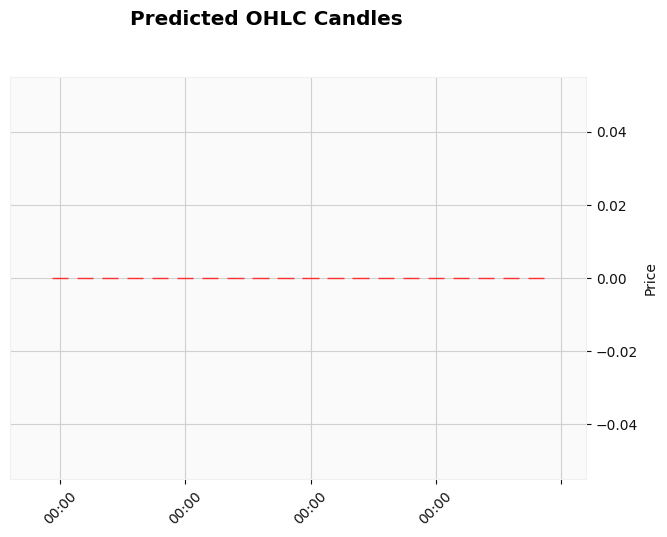

In [ ]:
# Import the necessary libraries
import mplfinance as mpf

# Convert predictions_scaled to a DataFrame
predictions_df = pd.DataFrame(predictions_scaled[-20:], columns=['Open', 'High', 'Low', 'Close'])

# Create a DataFrame with the timestamps for the last 100 data points
timestamps = last_100_actual_df.index[-20:]
timestamps_df = pd.DataFrame(timestamps, columns=['Date'])

# Concatenate the timestamps DataFrame with the predictions DataFrame
predictions_df = pd.concat([timestamps_df, predictions_df], axis=1)

# Convert the index of predictions_df to DatetimeIndex
predictions_df.index = pd.to_datetime(predictions_df.index)

# Plot the predicted OHLC candles
mpf.plot(predictions_df, type='candle', style='yahoo', title='Predicted OHLC Candles', ylabel='Price')

In [ ]:
# # Scale the predictions back to original values
# predictions = scaler.inverse_transform(predictions)
# y_test_reshaped = scaler.inverse_transform(y_test_reshaped)

# # Reshape y_test_reshaped back to its original shape
# y_test_reshaped = np.reshape(y_test_reshaped, (y_test.shape[0], y_test.shape[1], y_test.shape[2]))

In [ ]:
import ccxt
from datetime import datetime, timedelta
timeframe = '1m'
symbol = 'BTC/USDT'
minutes = 120 
since = datetime.now() - timedelta(minutes=minutes)
since = int(since.timestamp() * 1000)
limit = minutes+1
show_more_graph = False
exchange = ccxt.binance()

In [ ]:
last_60_minutes = exchange.fetch_ohlcv('BTC/USDT', timeframe=timeframe, since=since, limit=limit)
last_60_minutes = pd.DataFrame(last_60_minutes, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
last_60_minutes['Timestamp'] = pd.to_datetime(last_60_minutes['Timestamp'], unit='ms')
# drop Volume column
last_60_minutes.drop(columns=['Volume'], inplace=True)
last_60_minutes.set_index('Timestamp', inplace=True)
last_60_minutes.index = last_60_minutes.index + pd.DateOffset(hours=2)
last_60_minutes.tail(1)

,Open,High,Low,Close
Timestamp,,,,
2023-06-20 11:30:00,26749.63,26749.63,26740.0,26740.36


In [ ]:
# Scale the data to be values between 0 and 1
last_60_minutes_scaled = scaler.fit_transform(last_60_minutes[['Open', 'High', 'Low', 'Close']])

# Reshape the data into the shape accepted by the LSTM model
last_60_minutes_scaled = np.reshape(last_60_minutes_scaled, (1, last_60_minutes_scaled.shape[0], last_60_minutes_scaled.shape[1]))

# Make predictions using the LSTM model
pred = model.predict(last_60_minutes_scaled)
# Inverse transform the predictions to the original scale
pred = scaler.inverse_transform(pred)
print(pred[0])

1/1 [==============================] - 0s 18ms/step
[26795.469 26796.715 26792.398 26793.936]


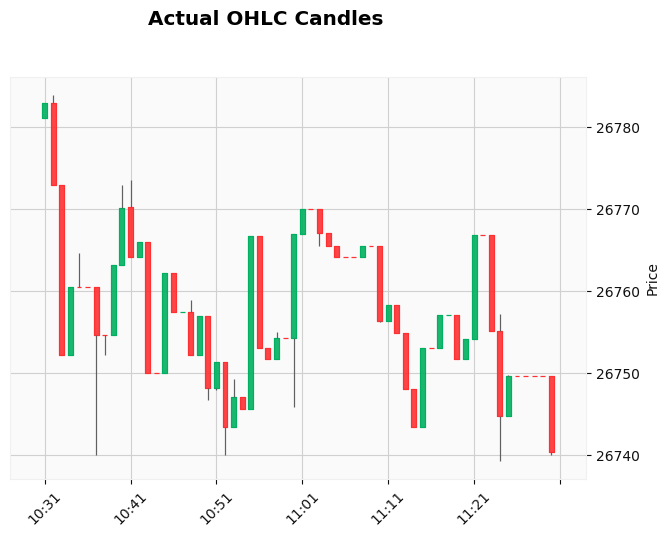

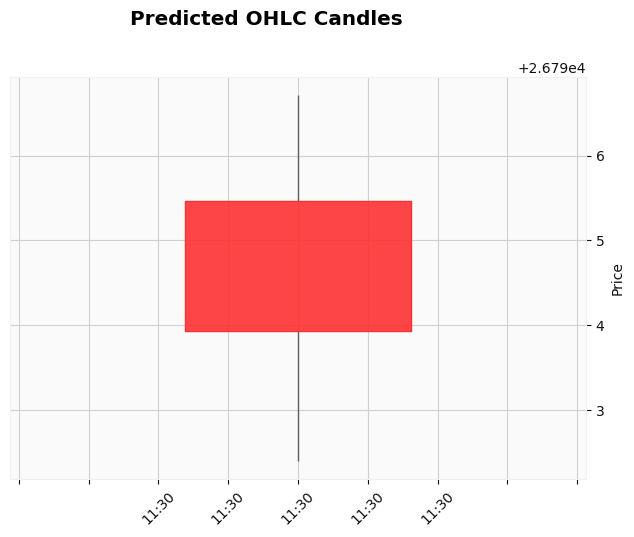

In [ ]:
import mplfinance as mpf

window = 60

# Extract the last 100 data points
last_100_actual = last_60_minutes[-window:]
last_100_predicted = pred[-window:]

# Convert the data to a DataFrame with DatetimeIndex
last_100_actual_df = pd.DataFrame(last_100_actual, columns=['Open', 'High', 'Low', 'Close'])
last_100_actual_df.index = last_100_actual.index

# Reshape the predicted data to match the expected shape
pred_reshaped = pred.reshape(-1, 4)

# Create the DataFrame for predicted data
pred_df = pd.DataFrame(pred_reshaped, columns=['Open', 'High', 'Low', 'Close'])
pred_df.index = last_100_actual.index[-len(last_100_predicted):]  # Use the index of last_100_actual

# Plot the actual and predicted OHLC candles
mpf.plot(last_100_actual_df, type='candle', style='yahoo', title='Actual OHLC Candles', ylabel='Price')
mpf.plot(pred_df, type='candle', style='yahoo', title='Predicted OHLC Candles', ylabel='Price')

plt.show()


In [ ]:
import mplfinance as mpf
# Create a DataFrame for the real data
real_data = bitcoin_data[['Timestamp', 'Open', 'High', 'Low', 'Close']]
real_data.columns = ['Date', 'Open', 'High', 'Low', 'Close']
real_data.set_index('Date', inplace=True)

# Create a DataFrame for the predicted data
predicted_data = pd.DataFrame(predictions, columns=['Open', 'High', 'Low', 'Close'])
predicted_data.index = real_data.index[-len(predicted_data):]  # Set the same index as the real data

# Concatenate the real and predicted data into a single DataFrame
combined_data = pd.concat([real_data[-100:], predicted_data], axis=0)


In [ ]:
# Define the style for the plot
style = mpf.make_mpf_style(base_mpf_style='yahoo', gridstyle=':', y_on_right=True)


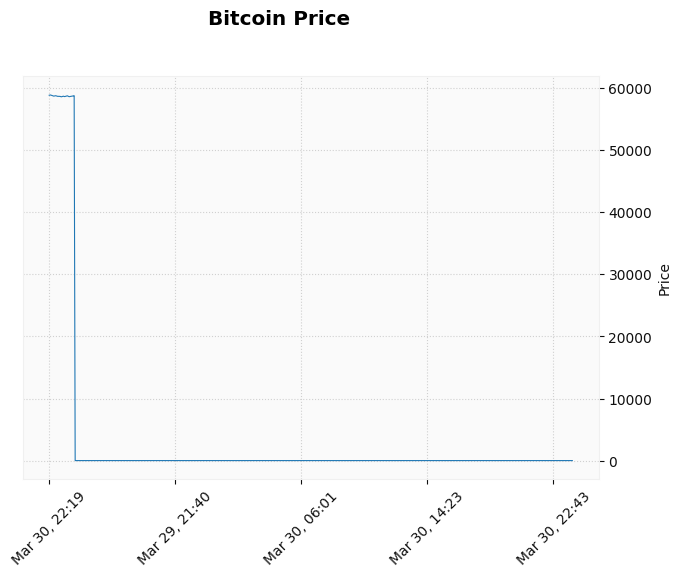

In [ ]:
# Plot the data using mplfinance
mpf.plot(combined_data, type='line', style=style, title='Bitcoin Price', ylabel='Price', ylabel_lower='Volume')
